In [4]:
import sys
sys.path.append('..')
import warnings
import numpy as np
import os
import pandas as pd
from nilearn.datasets.utils import _uncompress_file, _fetch_file
from nilearn.connectome import ConnectivityMeasure
import seaborn as sns

from joblib import Parallel, delayed

from statsmodels.formula.api import ols as ols_f

#from mlconfound.stats import generalization_test
#from mlconfound.plot import plot_graph, plot_null_dist

In [2]:
order = pd.read_csv('../data_in/MIST122_relabeled.tsv', sep='\t').iloc[:, 1:]
pheno = pd.read_csv('../../connattractor/notebooks/cobre_data/data_cobre_neuropsych.csv')

In [3]:
all_data = pd.DataFrame(columns=pheno.columns)

timeseries = []

for id in pheno.id:
    if os.path.exists('../../connattractor/notebooks/cobre_data/BASC/regions/' + id + '_timeseries.txt'):

        ts = np.loadtxt('../../connattractor/notebooks/cobre_data/BASC/networks/' + id + '_timeseries.txt')
        #reorder columns in ts based on order['index']
        ts = ts[:, order['index'].values-1]
        timeseries.append(ts)
        all_data.loc[id, pheno.columns] = pheno.loc[pheno.id == id, pheno.columns].values
        
all_data['study_group_int'] = pd.Categorical(all_data.study_group).codes
all_data['gender_int'] = pd.Categorical(all_data.gender).codes
all_data

,id,study_group,age,gender,WTAR_RawScore,WASI_Vocab_RawScore,WASI_Similarities_RawScore,WASI_BlockDesign_RawScore,WASI_MatrixReasoning_RawScore,WAIS_SymbolSearch_RawScore,...,CPT_II_Variability_Value,CPT_II_Detectability_Value,CPT_II_ResponseStyle_Value,CPT_II_Perseverations_Value,CPT_II_Hit_RT_BlockChange_Value,CPT_II_Hit_SE_BlockChange_Value,CPT_II_Hit_RT_ISI_Change_Value,CPT_II_Hit_SE_ISI_Change_Value,study_group_int,gender_int
A00000300,A00000300,Control,35,male,42,62,43,47,30,36,...,3.79,0.73,0.44,0.0,0.0,0.01,0.04,-0.06,0,1
A00000368,A00000368,Schizophrenia,52,male,31,56,33,26,28,20,...,3.49,1.03,0.63,0.0,-0.03,-0.07,0.08,0.07,1,1
A00000541,A00000541,Schizophrenia,48,female,25,51,36,33,24,30,...,25.25,1.05,1.26,2.0,0.01,0.11,0.11,0.14,1,0
A00000838,A00000838,Schizophrenia,28,male,38,44,39,71,28,32,...,9.58,0.4,0.72,0.0,0.03,0.01,0.11,0.08,1,1
A00000909,A00000909,Schizophrenia,27,male,20,35,26,58,29,30,...,13.96,0.39,0.16,0.0,-0.06,-0.15,0.1,0.21,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A00037649,A00037649,Schizophrenia,40,female,38,64,43,41,22,39,...,21.32,1.04,2.63,0.0,0.01,-0.02,0.08,0.18,1,0
A00037665,A00037665,Control,42,male,45,68,41,63,32,42,...,4.49,0.87,0.0,0.0,-0.01,-0.05,0.03,0.02,0,1
A00037854,A00037854,Schizophrenia,20,male,10,30,25,8,18,22,...,6.46,0.34,0.71,0.0,-0.02,-0.06,0.07,0.11,1,1
A00038441,A00038441,Schizophrenia,52,male,37,64,41,28,23,27,...,7.29,0.93,1.72,1.0,0.04,0.04,0.05,-0.03,1,1


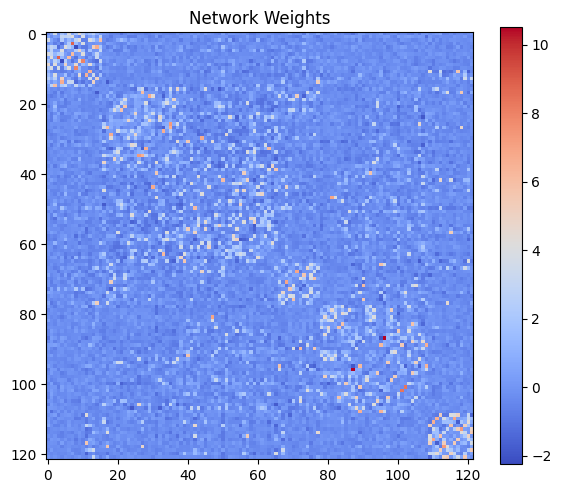

In [6]:
from connattractor import network

connections = ConnectivityMeasure(kind='partial correlation', vectorize=True, discard_diagonal=True)
idxs = np.where((all_data.study_group=='Control') | (all_data.study_group=='Schizophrenia'))[0]
conn_coefs = pd.DataFrame(connections.fit_transform(np.array(timeseries)[idxs]),
                          index=all_data.iloc[idxs, :].index)
mtx_ctr = connections.mean_
hopnet = network.Hopfield(mtx_ctr, scale=True)
hopnet.plot_weights()

In [7]:
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
import connattractor.statedynamics as sd

_threshold_ = 0

hopnet.beta = 0.043 # 4 states for group level connectome

_standardize_ts = True
_standardize_act = True

_TR_ = 3.0 #sec

# statedict is now group-level
statedict = []
meanacts = []
statelabels = []

for ts in tqdm(timeseries):
    # standardize timeseries
    ts = pd.DataFrame(data=ts)

    columns = ts.columns
    if _standardize_ts:
        ts = pd.DataFrame(StandardScaler().fit_transform(ts), columns=columns)

    # get all subject-level attractor states activations:
    attractor_states = sd.get_attractors_per_timesample(ts, hopnet)

    statelabel, statedict = sd.label_att_states(attractor_states, statedict)

    meanacts.append(sd.mean_state_activation(statedict, statelabel, ts, _standardize_act))
    statelabels.append(statelabel)
    
print('number of states:', len(statedict))

  0%|          | 0/132 [00:00<?, ?it/s]

number of states: 4


In [9]:
from connattractor.statedynamics import StateDynamics

statecontainer = StateDynamics()
statecontainer.read_meanactivation(meanacts)

## Stats

In [10]:
idx_ctr = np.where(all_data.study_group=='Control')[0]
idx_path = np.where(all_data.study_group=='Schizophrenia')[0]

In [11]:
labels_ctr = [arr for i, arr in enumerate(statelabels) if i in idx_ctr]
labels_path = [arr for i, arr in enumerate(statelabels) if i in idx_path]

In [12]:
# sort the activations according to group and state
act_ctr = {key: [] for key in range(len(statedict))}
act_sch = {key: [] for key in range(len(statedict))}

for idx, sub_ts in enumerate(timeseries):
    if idx in idx_ctr:
        for idx_label, label in enumerate(statelabels[idx]):
            act_ctr[label].append(sub_ts[idx_label])
    elif idx in idx_path:
        for idx_label, label in enumerate(statelabels[idx]):
            act_sch[label].append(sub_ts[idx_label])
    else:
        print('stuff')
    

In [13]:
# calc mean acts
mean_act_ctr = {}
mean_act_sch = {}

for state, acts in act_ctr.items():
    mean_act_ctr[state] = np.mean(acts, axis=0)
    
for state, acts in act_sch.items():
    mean_act_sch[state] = np.mean(acts, axis=0)

In [14]:
def workhorse(seed):
    random = np.random.default_rng(int(seed))
    timeseries_shuffled = timeseries.copy()
    timeseries_shuffled = random.permutation(timeseries_shuffled)
    
    for idx, sub_ts in enumerate(timeseries_shuffled):
        if idx in idx_ctr:
            for idx_label, label in enumerate(statelabels[idx]):
                act_ctr[label].append(sub_ts[idx_label])
        elif idx in idx_path:
            for idx_label, label in enumerate(statelabels[idx]):
                act_sch[label].append(sub_ts[idx_label])
                  
    mean_act_diff = {}

    for state, acts in act_ctr.items():
        mean_act_diff[state] = np.mean(acts, axis=0) - np.mean(act_sch[state], axis = 0)
        
    return mean_act_diff

In [15]:
from joblib import Parallel, delayed

n_perm = 1000

random = np.random.default_rng(42)
seeds = random.integers(0, np.iinfo(int).max, n_perm)

results = Parallel(n_jobs=-1)(delayed(workhorse)(seed) for seed in seeds)

In [16]:
# unpack the results
states_null_dist = {}

for idx, res in enumerate(results):
    if idx == 0:
        for state, acts in res.items():
            states_null_dist[state] = acts
            
    else:
        for state, acts in res.items():
            states_null_dist[state] = np.vstack([states_null_dist[state], acts]) 

# new vis

In [17]:
mean_act_path = mean_act_sch

In [18]:
# actual stats
alpha = 5
alpha_bnfr = 0.0102 # 5 /( 4 states and 122 regions)

sig_differences = {key: [] for key in range(len(statedict))}
act_differences = {key: [] for key in range(len(statedict))}

for state, null_dist in states_null_dist.items():
    actual_difference = mean_act_ctr[state] - mean_act_path[state]
    sig_difference = actual_difference.copy()
    for reg in range(np.shape(null_dist)[1]):
        alpha_threshold = np.percentile(null_dist[:, reg], 100 - alpha_bnfr)
        # if it doesnt pass the threshold, set to 0
        if actual_difference[reg] < alpha_threshold:
            sig_difference[reg] = 0
    sig_differences[state] = sig_difference
    act_differences[state] = actual_difference

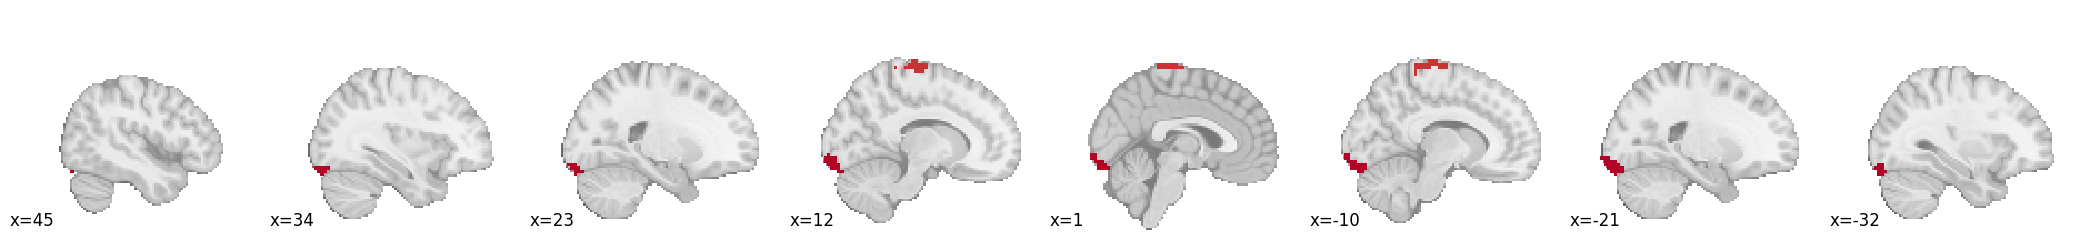

/home/renglert/PycharmProjects/connattractor_pub/venv/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


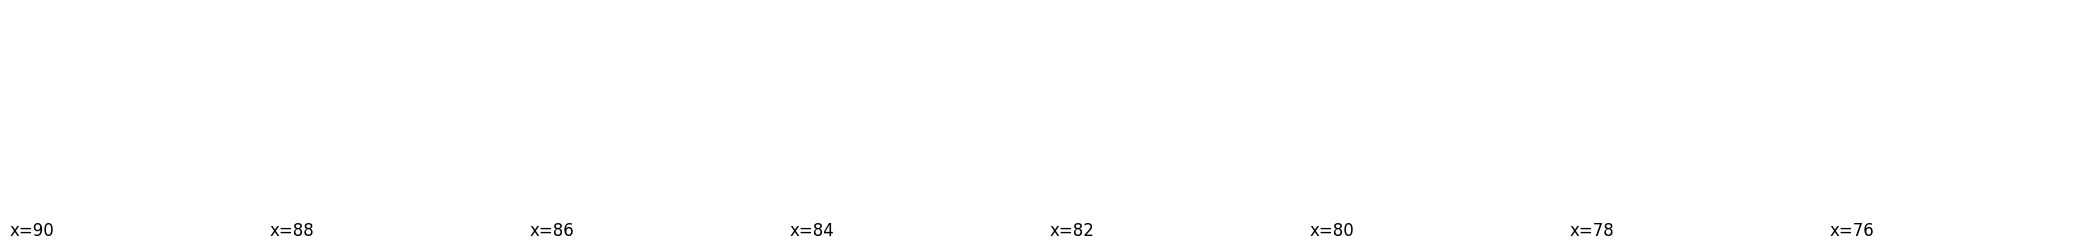

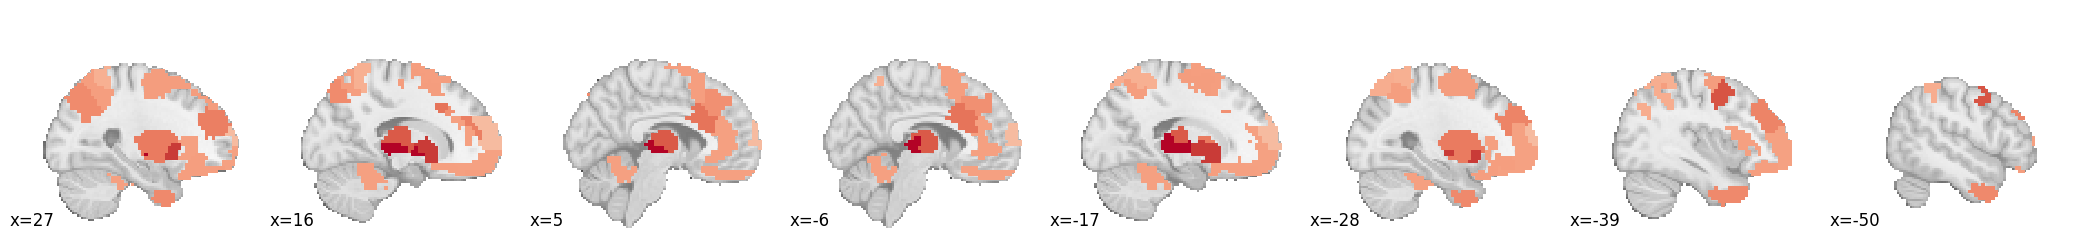

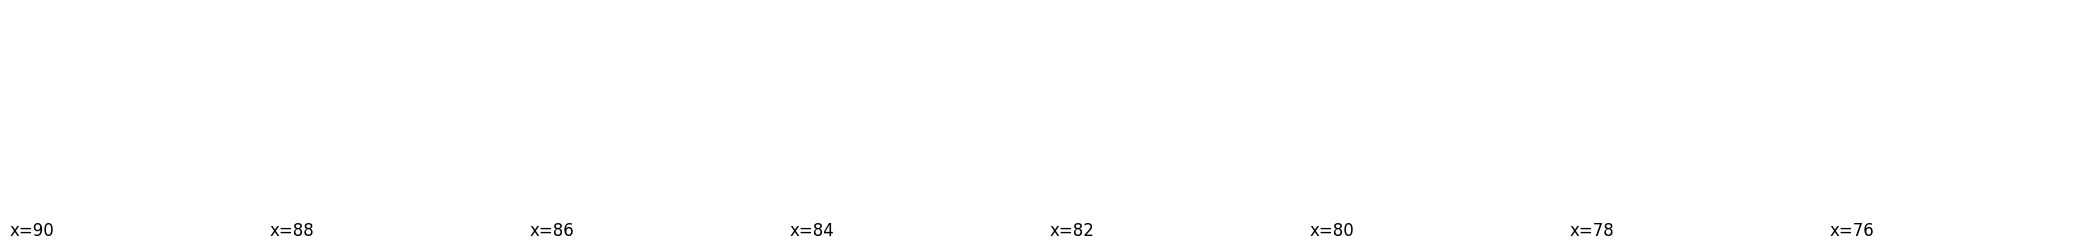

In [19]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import nilearn.plotting as plotting
# manually select slices to plot sig meanacts

roi_kwargs = {
    'display_mode': 'x',
    'cmap': cm.coolwarm,
    'cut_coords': (8),
    'colorbar': False,
    'threshold': 0,
    'draw_cross': False
}

for state in range(len(statedict)):
    plotting.plot_stat_map(network.State(sig_differences[state]).to_Nifti1Image(), **roi_kwargs)
    plt.show()

In [20]:
state_slices = {
    0: [1],
    1: [-10],
    2: [-17],
    3: [1]
}

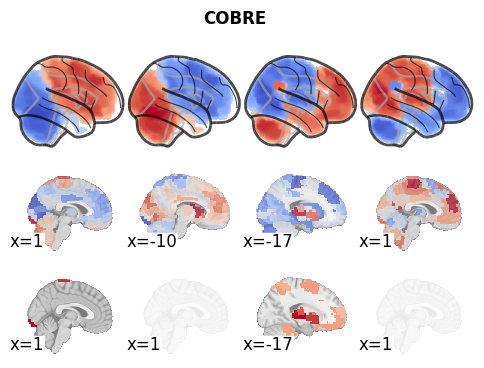

In [21]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
import nilearn.plotting as plotting


glassbrains_kwargs = {
            'display_mode': 'r',
            'colorbar': False,
            'plot_abs': False,
            'cmap': cm.coolwarm,
            }

roi_kwargs = {
    'display_mode': 'x',
    'cmap': cm.coolwarm,
    'colorbar': False,
    'threshold': 0,
    'draw_cross': False
}

roi_kwargs_empty = {
    'display_mode': 'x',
    'cmap': 'light-gray',
    'cut_coords': [1],
    'colorbar': False,
    'threshold': 0,
    'draw_cross': False,
    'alpha': 0.2,
    'dim': 10
}


fig, axes = plt.subplots(3, 4, figsize=(6, 4), gridspec_kw = {'wspace':0, 'hspace':0})

for state in range(len(statedict)):
    network.State(statedict[state]).plot(**glassbrains_kwargs, axes=axes[0, state])

    #network.State(actual_difference).plot(**glassbrains_kwargs, axes=axes[1, state])
    plotting.plot_roi(network.State(act_differences[state]).to_Nifti1Image(), 
                                      cut_coords=state_slices[state], **roi_kwargs, axes=axes[1, state])
    #network.State(sig_difference).plot(**glassbrains_kwargs, axes=axes[2, state])
    if any(reg != 0 for reg in sig_differences[state]):
        plotting.plot_stat_map(network.State(sig_differences[state]).to_Nifti1Image(), 
                               cut_coords=state_slices[state], **roi_kwargs, axes=axes[2, state])
    else:
        plotting.plot_stat_map(network.State(np.zeros(122)).to_Nifti1Image(), **roi_kwargs_empty, axes=axes[2, state])

children = axes[0, state].get_children()
        
fig.suptitle("COBRE", fontsize=12, fontweight='bold')

plt.subplots_adjust(top=0.8)
plt.savefig('../data_out/fig/COBRE_state_analysis.pdf')
plt.show()

In [21]:
import pickle

filename = '../data_out/cobre/cobre_meanacts.pckl'

with open(filename, 'wb') as f:
    pickle.dump(meanacts, f)

filename = '../data_out/cobre/cobre_connectome.pckl'

with open(filename, 'wb') as f:
    pickle.dump(mtx_ctr, f)

# Using the group specific hopnet

In [22]:
connections = ConnectivityMeasure(kind='partial correlation', vectorize=True, discard_diagonal=True)

idx_ctr = np.where(all_data.study_group=='Control')[0]
idx_path = np.where(all_data.study_group=='Schizophrenia')[0]

conn_coefs_ctr = pd.DataFrame(connections.fit_transform(np.array(timeseries)[idx_ctr]),
                          index=all_data.iloc[idx_ctr, :].index)
mtx_ctr = connections.mean_
hopnet_ctr = network.Hopfield(mtx_ctr, scale=True)

conn_coefs_path = pd.DataFrame(connections.fit_transform(np.array(timeseries)[idx_path]),
                          index=all_data.iloc[idx_path, :].index)
mtx_path = connections.mean_
hopnet_path = network.Hopfield(mtx_path, scale=True)

In [23]:
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
import connattractor.statedynamics as sd


_standardize_ts = True
_standardize_act = True

# statedict is now group-level
statedict_ctr = []
meanacts_ctr = []
statelabels_ctr = []

statedict_path = []
meanacts_path = []
statelabels_path = []

hopnet_ctr.beta = 0.0425
hopnet_path.beta = 0.043
#hopnet_path.beta = 0.044

for idx, ts in enumerate(tqdm(timeseries)):       
    # standardize timeseries
    ts = pd.DataFrame(data=ts)

    columns = ts.columns
    if _standardize_ts:
        ts = pd.DataFrame(StandardScaler().fit_transform(ts), columns=columns)
        
    if idx in idx_ctr:
        attractor_states = sd.get_attractors_per_timesample(ts, hopnet_ctr)
        statelabel, statedict_ctr = sd.label_att_states(attractor_states, statedict_ctr)
        meanacts_ctr.append(sd.mean_state_activation(statedict_ctr, statelabel, ts, _standardize_act))
        statelabels_ctr.append(statelabel)
    elif idx in idx_path:
        attractor_states = sd.get_attractors_per_timesample(ts, hopnet_path)
        statelabel, statedict_path = sd.label_att_states(attractor_states, statedict_path)
        meanacts_path.append(sd.mean_state_activation(statedict_path, statelabel, ts, _standardize_act))
        statelabels_path.append(statelabel)

    
print('number of states:', len(statedict_ctr))
print('number of states:', len(statedict_path))

  0%|          | 0/132 [00:00<?, ?it/s]

number of states: 4
number of states: 4


In [207]:
from connattractor.statedynamics import StateDynamics

sc_ctr = StateDynamics()
sc_ctr.read_meanactivation(meanacts_ctr)

sc_path = StateDynamics()
sc_path.read_meanactivation(meanacts_path)

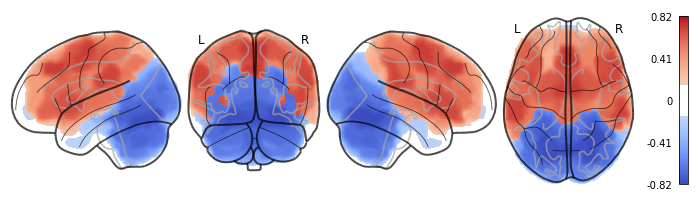

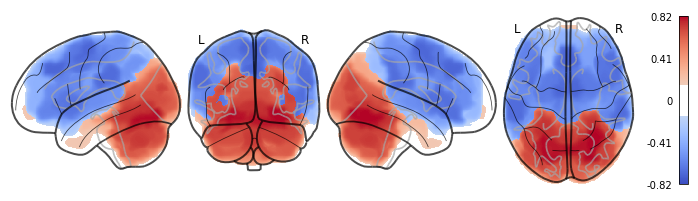

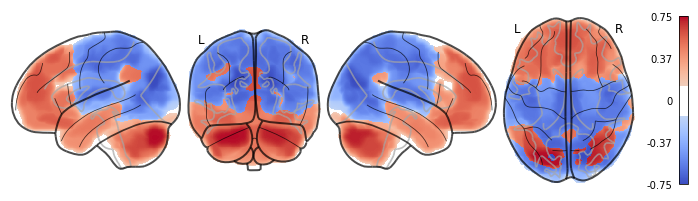

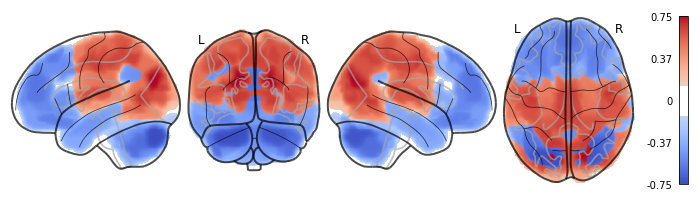

In [208]:
import matplotlib.pyplot as plt 

for state in statedict_ctr:
    network.State(state).plot()
    plt.show()

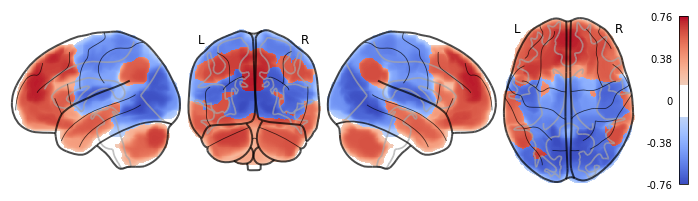

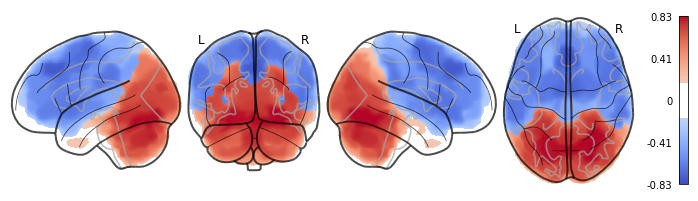

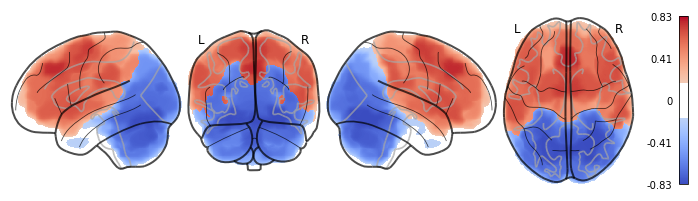

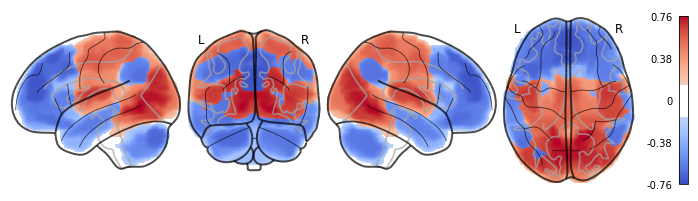

In [209]:
for state in statedict_path:
    network.State(state).plot()
    plt.show()

In [210]:
# swap the labels of the path group to match the control
# this is PATH: CTRL
mapping = {2: 0, 1: 1, 0: 2, 3: 3}

statelabels_path_mapped = [np.array([mapping.get(num, num) for num in arr]) for arr in statelabels_path]

In [211]:
# match indices and statelabels together
statelabels_combined = {k: v for k, v in zip(idx_ctr, statelabels_ctr)}
statelabels_combined.update({k: v for k, v in zip(idx_path, statelabels_path_mapped)})

In [216]:
# sort the activations according to group and state
act_ctr = {key: [] for key in range(len(statedict_ctr))}
act_path = {key: [] for key in range(len(statedict_path))}

for idx, sub_ts in enumerate(timeseries):
    if idx in idx_ctr:
        for idx_label, label in enumerate(statelabels_combined[idx]):
            act_ctr[label].append(sub_ts[idx_label])
    elif idx in idx_path:
        for idx_label, label in enumerate(statelabels_combined[idx]):
            act_path[label].append(sub_ts[idx_label])
    else:
        print('stuff')

In [219]:
# calc mean acts
mean_act_ctr = {}
mean_act_path = {}

for state, acts in act_ctr.items():
    mean_act_ctr[state] = np.mean(acts, axis=0)
    
for state, acts in act_path.items():
    mean_act_path[state] = np.mean(acts, axis=0)

In [221]:
def workhorse2(seed):
    act_ctr = {key: [] for key in range(len(statedict_ctr))}
    act_path = {key: [] for key in range(len(statedict_path))}
    
    random = np.random.default_rng(int(seed))
    timeseries_shuffled = timeseries.copy()
    timeseries_shuffled = random.permutation(timeseries_shuffled)
    
    for idx, sub_ts in enumerate(timeseries_shuffled):
        if idx in idx_ctr:
            for idx_label, label in enumerate(statelabels_combined[idx]):
                act_ctr[label].append(sub_ts[idx_label])
        elif idx in idx_sch:
            for idx_label, label in enumerate(statelabels_combined[idx]):
                act_path[label].append(sub_ts[idx_label])
                  
    mean_act_diff = {}

    for state, acts in act_ctr.items():
        mean_act_diff[state] = np.mean(acts, axis=0) - np.mean(act_path[state], axis = 0)
        
    return mean_act_diff

In [222]:
from joblib import Parallel, delayed

n_perm = 1000

random = np.random.default_rng(42)
seeds = random.integers(0, np.iinfo(int).max, n_perm)

results = Parallel(n_jobs=-1)(delayed(workhorse2)(seed) for seed in seeds)

In [223]:
# unpack the results
states_null_dist = {}

for idx, res in enumerate(results):
    if idx == 0:
        for state, acts in res.items():
            states_null_dist[state] = acts
            
    else:
        for state, acts in res.items():
            states_null_dist[state] = np.vstack([states_null_dist[state], acts]) 

State 0


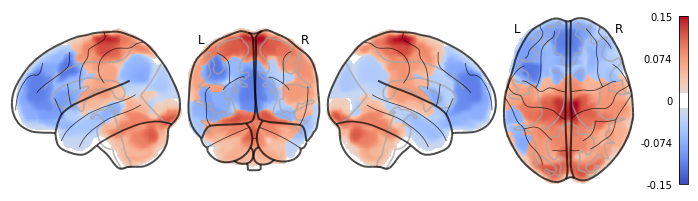

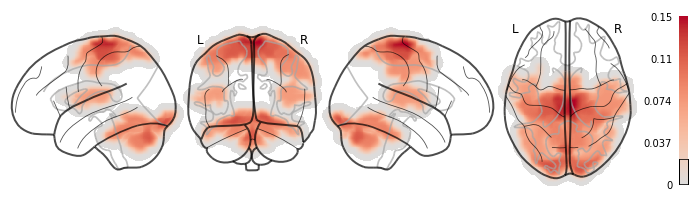

State 1


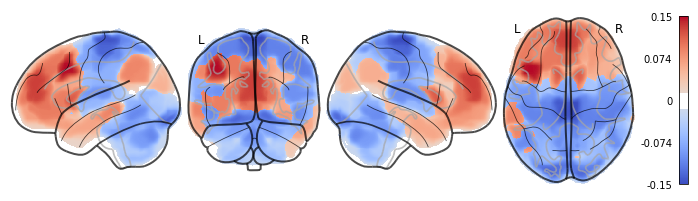

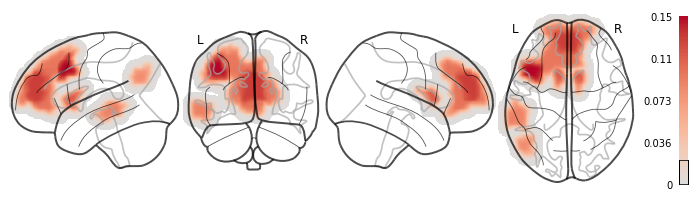

State 2


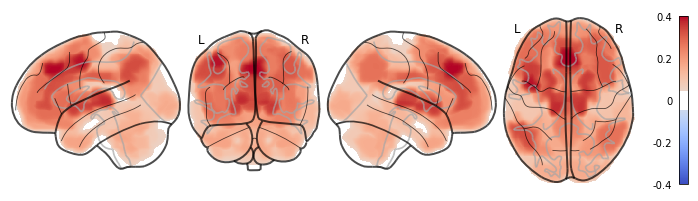

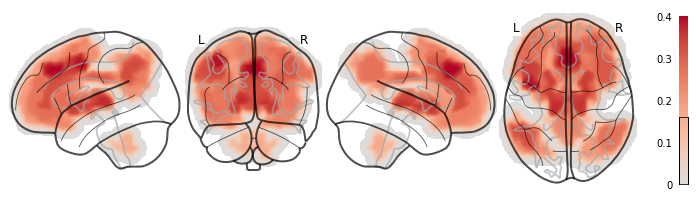

State 3


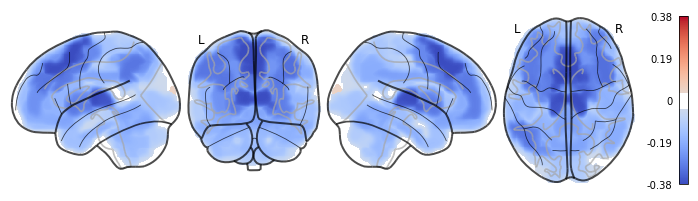

/home/renglert/PycharmProjects/connattractor/venv/lib/python3.8/site-packages/nilearn/plotting/displays.py:786: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


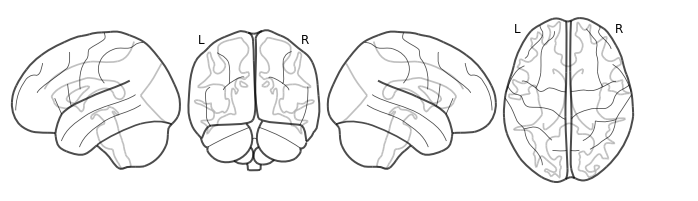

In [224]:
alpha = 5
alpha_bnfr = 0.0102 # 5 /( 4 states and 122 regions)

for state, null_dist in states_null_dist.items():
    print(f'State {state}')
    actual_difference = mean_act_ctr[state] - mean_act_path[state]
    sig_difference = actual_difference.copy()
    for reg in range(np.shape(null_dist)[1]):
        alpha_threshold = np.percentile(null_dist[:, reg], 100 - alpha_bnfr)
        # if it doesnt pass the threshold, set to 0
        if actual_difference[reg] < alpha_threshold:
            sig_difference[reg] = 0
    network.State(actual_difference).plot()
    plt.show()
    network.State(sig_difference).plot()
    plt.show()